# Notebook 3: Trying with last 3 days input data

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


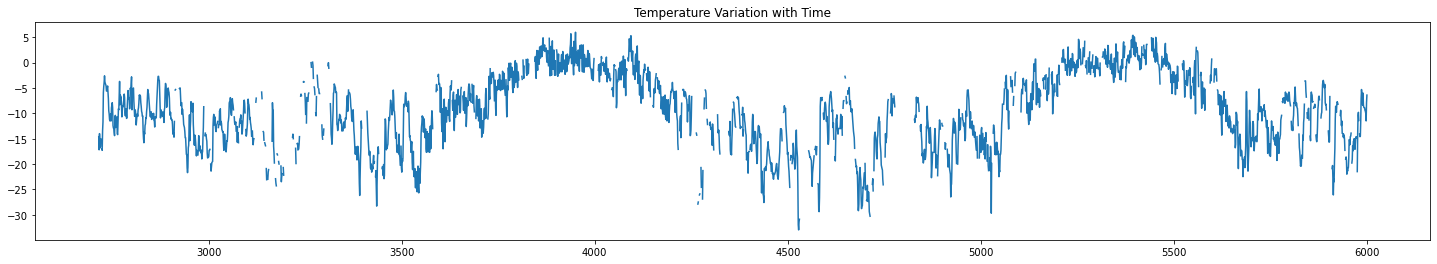

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=5):
    df = dataframe.copy()
    for lag in range(1, prev_n_days+1):
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=3)

In [11]:
y

array([-15.5, -16.8, -16.5, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[-14. ],
        [-17.2],
        [-14.6]],

       [[-15.5],
        [-14. ],
        [-17.2]],

       [[-16.8],
        [-15.5],
        [-14. ]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -9.4]],

       [[-11.5],
        [-10. ],
        [ -9.6]],

       [[ -7.9],
        [-11.5],
        [-10. ]]])

# Temporal splitting

In [13]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

1462 1775


# Standardization

In [14]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [15]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [16]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs1',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [17]:
model1 = Sequential()
model1.add(InputLayer((3,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [19]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 105.8300 - root_mean_squared_error: 10.2874

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 21s 353ms/step - loss: 105.8300 - root_mean_squared_error: 10.2874 - val_loss: 18.7910 - val_root_mean_squared_error: 4.3349
Epoch 2/50
44/46 [===========================>..] - ETA: 0s - loss: 34.9898 - root_mean_squared_error: 5.9152

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 256ms/step - loss: 34.4375 - root_mean_squared_error: 5.8683 - val_loss: 11.1706 - val_root_mean_squared_error: 3.3422
Epoch 3/50
44/46 [===========================>..] - ETA: 0s - loss: 15.3613 - root_mean_squared_error: 3.9194

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 272ms/step - loss: 15.4344 - root_mean_squared_error: 3.9287 - val_loss: 6.5894 - val_root_mean_squared_error: 2.5670
Epoch 4/50
43/46 [===========================>..] - ETA: 0s - loss: 10.0559 - root_mean_squared_error: 3.1711

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 269ms/step - loss: 10.0299 - root_mean_squared_error: 3.1670 - val_loss: 5.9319 - val_root_mean_squared_error: 2.4356
Epoch 5/50
41/46 [=========================>....] - ETA: 0s - loss: 8.3377 - root_mean_squared_error: 2.8875

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 11s 245ms/step - loss: 8.3691 - root_mean_squared_error: 2.8929 - val_loss: 5.5462 - val_root_mean_squared_error: 2.3550
Epoch 6/50
36/46 [======================>.......] - ETA: 0s - loss: 7.2458 - root_mean_squared_error: 2.6918

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 264ms/step - loss: 7.1113 - root_mean_squared_error: 2.6667 - val_loss: 5.2546 - val_root_mean_squared_error: 2.2923
Epoch 7/50
41/46 [=========================>....] - ETA: 0s - loss: 6.1357 - root_mean_squared_error: 2.4770

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 271ms/step - loss: 6.0278 - root_mean_squared_error: 2.4552 - val_loss: 5.0206 - val_root_mean_squared_error: 2.2407
Epoch 8/50
42/46 [==========================>...] - ETA: 0s - loss: 5.5912 - root_mean_squared_error: 2.3646

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 282ms/step - loss: 5.4469 - root_mean_squared_error: 2.3339 - val_loss: 4.9951 - val_root_mean_squared_error: 2.2350
Epoch 9/50
46/46 [==============================] - 0s 7ms/step - loss: 5.0031 - root_mean_squared_error: 2.2368 - val_loss: 4.9984 - val_root_mean_squared_error: 2.2357
Epoch 10/50
41/46 [=========================>....] - ETA: 0s - loss: 4.8234 - root_mean_squared_error: 2.1962

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 285ms/step - loss: 4.8088 - root_mean_squared_error: 2.1929 - val_loss: 4.9801 - val_root_mean_squared_error: 2.2316
Epoch 11/50
46/46 [==============================] - 0s 6ms/step - loss: 4.6233 - root_mean_squared_error: 2.1502 - val_loss: 5.0155 - val_root_mean_squared_error: 2.2395
Epoch 12/50
42/46 [==========================>...] - ETA: 0s - loss: 4.6605 - root_mean_squared_error: 2.1588

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 265ms/step - loss: 4.6500 - root_mean_squared_error: 2.1564 - val_loss: 4.9517 - val_root_mean_squared_error: 2.2252
Epoch 13/50
36/46 [======================>.......] - ETA: 0s - loss: 4.4848 - root_mean_squared_error: 2.1177

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 264ms/step - loss: 4.4208 - root_mean_squared_error: 2.1026 - val_loss: 4.9306 - val_root_mean_squared_error: 2.2205
Epoch 14/50
46/46 [==============================] - ETA: 0s - loss: 4.2757 - root_mean_squared_error: 2.0678

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 11s 254ms/step - loss: 4.2757 - root_mean_squared_error: 2.0678 - val_loss: 4.8551 - val_root_mean_squared_error: 2.2034
Epoch 15/50
35/46 [=====================>........] - ETA: 0s - loss: 4.2676 - root_mean_squared_error: 2.0658

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 11s 254ms/step - loss: 4.2522 - root_mean_squared_error: 2.0621 - val_loss: 4.8435 - val_root_mean_squared_error: 2.2008
Epoch 16/50
42/46 [==========================>...] - ETA: 0s - loss: 4.2407 - root_mean_squared_error: 2.0593

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 267ms/step - loss: 4.2126 - root_mean_squared_error: 2.0525 - val_loss: 4.7447 - val_root_mean_squared_error: 2.1782
Epoch 17/50
42/46 [==========================>...] - ETA: 0s - loss: 4.0792 - root_mean_squared_error: 2.0197

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 11s 250ms/step - loss: 4.0802 - root_mean_squared_error: 2.0200 - val_loss: 4.6546 - val_root_mean_squared_error: 2.1574
Epoch 18/50
44/46 [===========================>..] - ETA: 0s - loss: 4.0743 - root_mean_squared_error: 2.0185

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 270ms/step - loss: 4.0469 - root_mean_squared_error: 2.0117 - val_loss: 4.6049 - val_root_mean_squared_error: 2.1459
Epoch 19/50
46/46 [==============================] - 0s 7ms/step - loss: 3.8829 - root_mean_squared_error: 1.9705 - val_loss: 4.7571 - val_root_mean_squared_error: 2.1811
Epoch 20/50
35/46 [=====================>........] - ETA: 0s - loss: 3.9406 - root_mean_squared_error: 1.9851

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 278ms/step - loss: 4.0969 - root_mean_squared_error: 2.0241 - val_loss: 4.5117 - val_root_mean_squared_error: 2.1241
Epoch 21/50
41/46 [=========================>....] - ETA: 0s - loss: 3.9734 - root_mean_squared_error: 1.9934

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 17s 383ms/step - loss: 4.0158 - root_mean_squared_error: 2.0040 - val_loss: 4.4641 - val_root_mean_squared_error: 2.1129
Epoch 22/50
46/46 [==============================] - 2s 40ms/step - loss: 3.9895 - root_mean_squared_error: 1.9974 - val_loss: 4.4731 - val_root_mean_squared_error: 2.1150
Epoch 23/50
46/46 [==============================] - 1s 13ms/step - loss: 3.8905 - root_mean_squared_error: 1.9724 - val_loss: 4.5374 - val_root_mean_squared_error: 2.1301
Epoch 24/50
40/46 [=========================>....] - ETA: 0s - loss: 3.9619 - root_mean_squared_error: 1.9904

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 282ms/step - loss: 3.8557 - root_mean_squared_error: 1.9636 - val_loss: 4.4183 - val_root_mean_squared_error: 2.1020
Epoch 25/50
46/46 [==============================] - 0s 6ms/step - loss: 3.7823 - root_mean_squared_error: 1.9448 - val_loss: 4.6567 - val_root_mean_squared_error: 2.1579
Epoch 26/50
36/46 [======================>.......] - ETA: 0s - loss: 4.0213 - root_mean_squared_error: 2.0053

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 259ms/step - loss: 4.0246 - root_mean_squared_error: 2.0061 - val_loss: 4.3083 - val_root_mean_squared_error: 2.0756
Epoch 27/50
46/46 [==============================] - 0s 6ms/step - loss: 4.0462 - root_mean_squared_error: 2.0115 - val_loss: 4.3228 - val_root_mean_squared_error: 2.0791
Epoch 28/50
41/46 [=========================>....] - ETA: 0s - loss: 3.8282 - root_mean_squared_error: 1.9566

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 11s 246ms/step - loss: 3.7872 - root_mean_squared_error: 1.9461 - val_loss: 4.3029 - val_root_mean_squared_error: 2.0744
Epoch 29/50
46/46 [==============================] - 0s 7ms/step - loss: 3.8328 - root_mean_squared_error: 1.9577 - val_loss: 4.5251 - val_root_mean_squared_error: 2.1272
Epoch 30/50
36/46 [======================>.......] - ETA: 0s - loss: 3.7961 - root_mean_squared_error: 1.9484

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 29s 644ms/step - loss: 3.8157 - root_mean_squared_error: 1.9534 - val_loss: 4.3019 - val_root_mean_squared_error: 2.0741
Epoch 31/50
35/46 [=====================>........] - ETA: 0s - loss: 3.6958 - root_mean_squared_error: 1.9224

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 282ms/step - loss: 3.7165 - root_mean_squared_error: 1.9278 - val_loss: 4.2855 - val_root_mean_squared_error: 2.0701
Epoch 32/50
44/46 [===========================>..] - ETA: 0s - loss: 3.7002 - root_mean_squared_error: 1.9236

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 276ms/step - loss: 3.7428 - root_mean_squared_error: 1.9346 - val_loss: 4.2622 - val_root_mean_squared_error: 2.0645
Epoch 33/50
41/46 [=========================>....] - ETA: 0s - loss: 3.6958 - root_mean_squared_error: 1.9224

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 13s 285ms/step - loss: 3.6441 - root_mean_squared_error: 1.9090 - val_loss: 4.2358 - val_root_mean_squared_error: 2.0581
Epoch 34/50
46/46 [==============================] - 0s 7ms/step - loss: 3.7627 - root_mean_squared_error: 1.9398 - val_loss: 4.2811 - val_root_mean_squared_error: 2.0691
Epoch 35/50
46/46 [==============================] - 0s 7ms/step - loss: 3.8079 - root_mean_squared_error: 1.9514 - val_loss: 4.2487 - val_root_mean_squared_error: 2.0612
Epoch 36/50
43/46 [===========================>..] - ETA: 0s - loss: 3.7457 - root_mean_squared_error: 1.9354

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 12s 272ms/step - loss: 3.7260 - root_mean_squared_error: 1.9303 - val_loss: 4.1665 - val_root_mean_squared_error: 2.0412
Epoch 37/50
46/46 [==============================] - 0s 6ms/step - loss: 3.6407 - root_mean_squared_error: 1.9081 - val_loss: 4.2100 - val_root_mean_squared_error: 2.0518
Epoch 38/50
46/46 [==============================] - ETA: 0s - loss: 3.7620 - root_mean_squared_error: 1.9396

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 15s 331ms/step - loss: 3.7620 - root_mean_squared_error: 1.9396 - val_loss: 4.1516 - val_root_mean_squared_error: 2.0376
Epoch 39/50
46/46 [==============================] - 1s 16ms/step - loss: 3.7200 - root_mean_squared_error: 1.9287 - val_loss: 4.1571 - val_root_mean_squared_error: 2.0389
Epoch 40/50
39/46 [========================>.....] - ETA: 0s - loss: 3.6188 - root_mean_squared_error: 1.9023

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 16s 344ms/step - loss: 3.7270 - root_mean_squared_error: 1.9305 - val_loss: 4.1273 - val_root_mean_squared_error: 2.0316
Epoch 41/50
45/46 [============================>.] - ETA: 0s - loss: 3.6050 - root_mean_squared_error: 1.8987

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 17s 380ms/step - loss: 3.6149 - root_mean_squared_error: 1.9013 - val_loss: 4.1047 - val_root_mean_squared_error: 2.0260
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 3.6491 - root_mean_squared_error: 1.9103 - val_loss: 4.1454 - val_root_mean_squared_error: 2.0360
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 3.6131 - root_mean_squared_error: 1.9008 - val_loss: 4.1927 - val_root_mean_squared_error: 2.0476
Epoch 44/50
37/46 [=======================>......] - ETA: 0s - loss: 3.6041 - root_mean_squared_error: 1.8984

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 14s 302ms/step - loss: 3.6242 - root_mean_squared_error: 1.9037 - val_loss: 4.0519 - val_root_mean_squared_error: 2.0129
Epoch 45/50
41/46 [=========================>....] - ETA: 0s - loss: 3.7682 - root_mean_squared_error: 1.9412

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 15s 332ms/step - loss: 3.7301 - root_mean_squared_error: 1.9313 - val_loss: 4.0438 - val_root_mean_squared_error: 2.0109
Epoch 46/50
46/46 [==============================] - ETA: 0s - loss: 3.6683 - root_mean_squared_error: 1.9153

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 15s 334ms/step - loss: 3.6683 - root_mean_squared_error: 1.9153 - val_loss: 4.0074 - val_root_mean_squared_error: 2.0018
Epoch 47/50
38/46 [=======================>......] - ETA: 0s - loss: 3.6778 - root_mean_squared_error: 1.9178

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 15s 327ms/step - loss: 3.6356 - root_mean_squared_error: 1.9067 - val_loss: 3.9953 - val_root_mean_squared_error: 1.9988
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 3.6965 - root_mean_squared_error: 1.9226 - val_loss: 4.0121 - val_root_mean_squared_error: 2.0030
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 3.6548 - root_mean_squared_error: 1.9117 - val_loss: 4.0029 - val_root_mean_squared_error: 2.0007
Epoch 50/50
46/46 [==============================] - ETA: 0s - loss: 3.6269 - root_mean_squared_error: 1.9044

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


46/46 [==============================] - 19s 416ms/step - loss: 3.6269 - root_mean_squared_error: 1.9044 - val_loss: 3.9538 - val_root_mean_squared_error: 1.9884


In [20]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

46/46 [==============================] - 0s 7ms/step


In [23]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 2.6543938186985576'}>

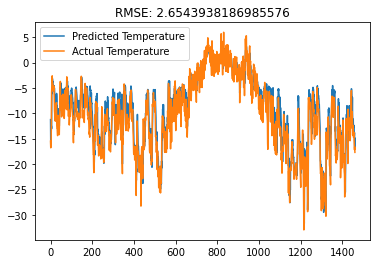

In [24]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.045258097214259'}>

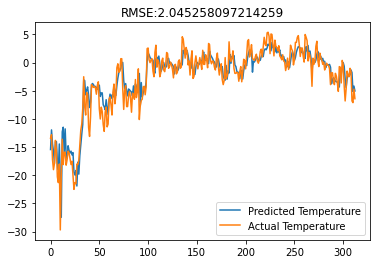

In [25]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.8252405213623435'}>

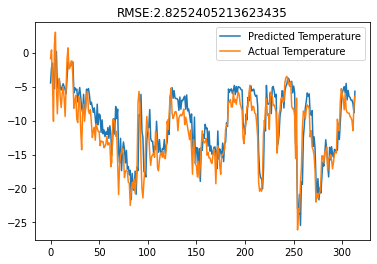

In [26]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [27]:
y_train.shape

(1462,)

Model performance improved using last 3 values only compared to last 5, 10 days value